# Lognormal mocks

Our eventual goal is to compare a direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will do this comparison on mock data. In this notebook, we show how to generate a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering the quarter of the sky with $|\cos\theta|<1/2$ and $\pi/2 < \phi < 3\pi/2$.

In [3]:
import numpy  as np
import healpy as hp

In [4]:
# Get a random number generator.
rng = np.random.default_rng()

In [5]:
# Code to generate a lognormal catalog of approximately Npnt
# points, assuming a Gaussian angular power spectrum, clg.
def lognormal_catalog(Npnt,clg,nside=256):
    """Returns (theta,phi,wt) for about Npnt points.  This
    should be run with Npnt<<Npix=12*nside^2."""
    gmap = hp.synfast(clg,nside,alm=False,pol=False)
    print("gmap in range ({:e},{:e})".format(np.min(gmap),np.max(gmap)))
    emap = np.exp(gmap)
    emap*= Npnt/np.sum(emap)
    print("emap in range ({:e},{:e})".format(np.min(emap),np.max(emap)))
    ngal = rng.poisson(lam=emap,size=emap.size)
    ipix = np.nonzero(ngal>0)[0]
    thta,phi = hp.pix2ang(nside,ipix,lonlat=False)
    wt   = np.ones_like(thta)
    # Now very slightly perturb the positions away from
    # the pixel centers.
    blur = np.sqrt( hp.pixelfunc.nside2pixarea(nside) )
    thta+= blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    phi += blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    return( (thta,phi,wt) )

In [6]:
# Generate points -- start with full sky
ell  = np.arange(1000)
ell0 = 10.
clg  = 0.001 * (ell0/(ell+ell0))**(1.1)
nside= 2048
npnt = 4 * 100000
thetas,phis,wts = lognormal_catalog(npnt,clg,nside)
# and cut to the "observed region"
cost = np.cos(thetas)
ww   = np.nonzero( (np.abs(cost)<0.5)&\
                   (phis>np.pi/2)&(phis<3*np.pi/2) )[0]
thetas,phis,wts = thetas[ww],phis[ww],wts[ww]
#
npnt = len(thetas)
nbar = npnt / (4*np.pi) # Objects/sr.
#
print("Kept {:d} objects in cut.".format(len(wts)))

gmap in range (-5.189997e+00,5.310756e+00)
emap in range (2.594034e-05,9.427461e-01)
Kept 101566 objects in cut.


In [7]:
# Generate a random catalog.
nrand = 10*len(thetas)
trand = np.arccos( rng.uniform(low=-0.5,high=0.5,size=nrand) )
prand = rng.uniform(low=np.pi/2,high=3*np.pi/2,size=nrand)
wrand = np.ones_like(trand) * float(npnt)/float(trand.size)

In [8]:
# If we wanted to put more structure in the mask
# here we could "cut out" various pieces of the
# disk, vetoing both data and random points.

In [16]:
# Note that the lognormal_catalog() function can also be called as
import sys
sys.path.append('../sht')
from  mocks import lognormal_catalog as lnc

lnc(npnt,clg,nside)

(array([0.0074939 , 0.00482178, 0.01514592, ..., 3.13079972, 3.1304636 ,
        3.13820491]),
 array([2.35900151, 5.49607274, 1.96660282, ..., 1.17865297, 1.9616092 ,
        5.49819996]),
 array([1., 1., 1., ..., 1., 1., 1.]))

Let's visualize these maps

In [8]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

dmap.sum= 1589057711.315823
rmap.sum= 1589057711.3172739


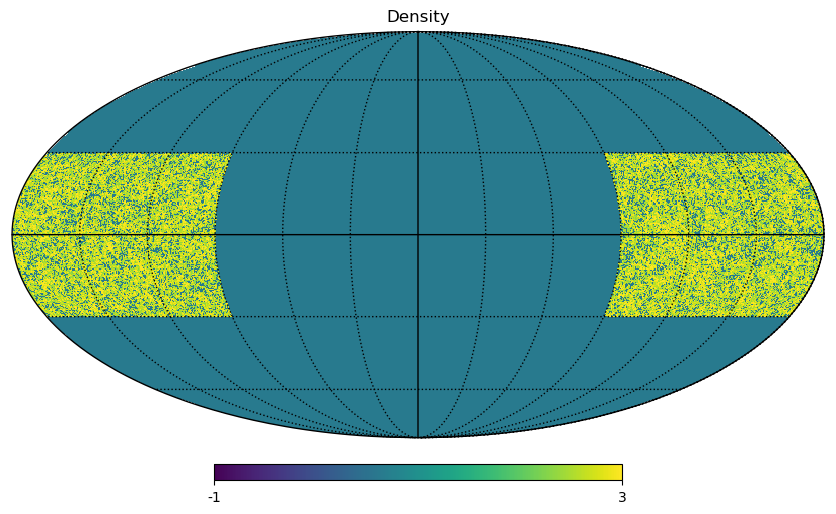

In [10]:
# Show an example at some nside.
# Eventually want to plot in grey the masked region
# and make it look pretty.
nside= 128
dmap = make_map(thetas,phis,wts  ,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
dmap[rmap<=0]=0.0
dmap = dmap/(rmap+1e-30)
ma   = hp.pixelfunc.ma(dmap)
hp.mollview(dmap,min=-1,max=3,norm='hist',title='Density')
hp.graticule()

# The End